In [46]:
from google.colab import files
uploaded = files.upload()
import zipfile, os

# Unzip the file (replace the name below if it's different)
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

# See what files got unzipped
print("Files inside the 'data' folder:")
print(os.listdir('data'))


KeyboardInterrupt: 

In [ ]:
import zipfile, os

with zipfile.ZipFile('archive (1).zip', 'r') as zip_ref:  # <-- change if needed
    zip_ref.extractall('data')

print("Files inside data folder:")
print(os.listdir('data'))



In [ ]:
df.info()
df.describe()
df.isnull().sum()


In [ ]:
# 1) Download your zip from GitHub (use ?raw=1 to get the file itself)
zip_url = "https://github.com/JustinGay115/data-investigation-Justingay/blob/main/archive%20(1).zip?raw=1"

import requests, pathlib
pathlib.Path("data").mkdir(exist_ok=True)
with open("archive.zip", "wb") as f:
    f.write(requests.get(zip_url).content)

print("Downloaded: archive.zip")


In [ ]:
import zipfile, os

with zipfile.ZipFile("archive.zip", "r") as z:
    z.extractall("data")

print("Files inside data/:")
print(os.listdir("data"))


In [ ]:
import glob, pandas as pd, os

csvs = glob.glob("data/*.csv")
print("CSV files found:", csvs)

if not csvs:
    raise FileNotFoundError("No CSV found in data/. Check the zip contents above.")

CSV_PATH = csvs[0]      # pick the first CSV automatically
print("Loading:", CSV_PATH)

df = pd.read_csv(CSV_PATH, low_memory=False)
df.head()


In [ ]:
print("Shape:", df.shape)
print("\nInfo:")
df.info()
print("\nMissing values (top 20):")
print(df.isnull().sum().sort_values(ascending=False).head(20))


In [ ]:
# Drop exact duplicates
df = df.drop_duplicates().copy()

# Separate numeric vs categorical
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Fill numeric NaNs with median
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill categorical NaNs with 'Unknown'
df[cat_cols] = df[cat_cols].fillna("Unknown")

print("Remaining missing values (top 20):")
print(df.isnull().sum().sort_values(ascending=False).head(20))


In [ ]:
import numpy as np

# Map lowercase->original column name so we can match common variations
cols = {c.lower(): c for c in df.columns}
get = lambda names: next((cols[n] for n in names if n in cols), None)

price   = get(["price","saleprice","sold_price","listing_price"])
sqft    = get(["sqft","square_feet","living_area","gr_liv_area","total_living_area"])
year    = get(["year_built","yr_built","yearbuilt"])
beds    = get(["bedrooms","beds","bed"])
baths   = get(["bathrooms","baths","bath"])
lot     = get(["lot_size","lotsize","lot_area","lot_sqft","lotarea"])

# 1) price per sqft
if price and sqft and (df[sqft] > 0).any():
    df["price_per_sqft"] = df[price] / df[sqft]

# 2) property age (as of 2025)
if year:
    df["property_age"] = 2025 - df[year]

# 3) bedrooms per 1000 sqft
if beds and sqft and (df[sqft] > 0).any():
    df["beds_per_1000sqft"] = (df[beds] / df[sqft]) * 1000

# 4) lot-to-living ratio
if lot and sqft and (df[sqft] > 0).any():
    df["lot_to_living_ratio"] = df[lot] / df[sqft]

# 5) expensive flag vs median price
if price:
    df["expensive_flag"] = df[price] > df[price].median()

df.head()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Price distribution
if price:
    sns.histplot(df[price], kde=True)
    plt.title("Distribution of Property Prices")
    plt.xlabel(price)
    plt.show()

# 2) Price vs Sqft
if price and sqft:
    sns.scatterplot(x=df[sqft], y=df[price], alpha=0.5)
    plt.title(f"{price} vs {sqft}")
    plt.xlabel(sqft); plt.ylabel(price)
    plt.show()

# 3) Price per sqft boxplot
if "price_per_sqft" in df.columns and df["price_per_sqft"].notna().any():
    sns.boxplot(x=df["price_per_sqft"])
    plt.title("Price per Sqft (Boxplot)")
    plt.show()

# 4) Correlation heatmap (numeric only)
corr = df.select_dtypes(include=["number"]).corr(numeric_only=True)
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric)")
plt.show()


In [59]:
df.columns.tolist()



['price',
 'area',
 'bedrooms',
 'bathrooms',
 'stories',
 'mainroad',
 'guestroom',
 'basement',
 'hotwaterheating',
 'airconditioning',
 'parking',
 'prefarea',
 'furnishingstatus']

In [ ]:
# Feature Engineering
import numpy as np

# 1. Price per area unit (acts like price per sqft)
df['price_per_area'] = df['price'] / df['area']

# 2. Total rooms (beds + baths)
df['total_rooms'] = df['bedrooms'] + df['bathrooms']

# 3. Price category (High, Medium, Low)
price_median = df['price'].median()
price_high = df['price'].quantile(0.75)
price_low = df['price'].quantile(0.25)

def categorize_price(value):
    if value >= price_high:
        return 'High'
    elif value <= price_low:
        return 'Low'
    else:
        return 'Medium'

df['price_category'] = df['price'].apply(categorize_price)

# 4. Luxury flag (air conditioning + guestroom + prefarea + price high)
df['luxury_flag'] = (
    (df['airconditioning'] == 'yes') &
    (df['guestroom'] == 'yes') &
    (df['prefarea'] == 'yes') &
    (df['price'] >= price_high)
)

# 5. Room density (rooms per 1000 sqft equivalent)
df['rooms_per_1000area'] = (df['total_rooms'] / df['area']) * 1000

df.head()


In [ ]:
print("Shape:", df.shape)
print("\nInfo:")
df.info()
print("\nMissing values by column:")
print(df.isnull().sum().sort_values(ascending=False))




In [ ]:
## 1) Dataset Selection & Justification (200–300 words)
I selected a real-estate dataset because that is what I plan on doing after school. Also,  pricing, acquisition, and portfolio strategy rely on quantifying how property characteristics translate into market value. Columns like price, area (size), bedrooms, bathrooms, stories, amenities (air conditioning, basement, parking), and location proxies (main road, preferred area) allow realistic valuation questions: How strongly does size drive price? Which amenities command a premium? What’s the price-per-area range across the dataset? Do “luxury” bundles (AC + guestroom + preferred area) meaningfully shift price?

For career relevance, this mirrors analyst workflows at brokerages, investors, proptech, and appraisal teams: profile data quality, engineer features that normalize comparisons (e.g., price per area), visualize patterns, and convert findings into recommendations. I’ll apply the Ask–Prepare–Process–Analyze–Share–Act framework, including: (1) defining business questions (price drivers; premium for features), (2) auditing completeness/consistency, (3) cleaning (duplicates, type normalization), (4) engineering features (price_per_area, total_rooms, rooms_per_1000area, luxury_flag, price_category), (5) EDA to surface relationships, and (6) summarizing insights and actions (e.g., pricing heuristics; amenity bundles to highlight).

This dataset suits the assignment rubric: ≥500 rows, ≥8 variables, mix of categorical and numeric, and realistic quirks (categorical “yes/no” normalization, potential outliers). The resulting notebook demonstrates end-to-end data handling, feature creation using domain logic, visual/statistical exploration, and stakeholder-ready takeaways for pricing and acquisition teams.


In [ ]:
import numpy as np

summary = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "n_unique": df.nunique(),
    "missing": df.isnull().sum(),
})
summary


In [ ]:
## 2) Data Dictionary
| Variable           | Type       | Expected Range / Categories | Business Meaning                                       |
|-------------------|------------|-----------------------------|--------------------------------------------------------|
| price             | numeric    | > 0                         | Property sale/listing price                            |
| area              | numeric    | > 0                         | Property size (acts like sqft)                         |
| bedrooms          | integer    | <10                        | Number of bedrooms                                     |
| bathrooms         | numeric    | <10                        | Number of bathrooms                                    |
| stories           | integer    | <4+                        | Number of stories/floors                               |
| mainroad          | categorical| yes/no                      | Whether on a main road                                 |
| guestroom         | categorical| yes/no                      | Whether a guest room exists                            |
| basement          | categorical| yes/no                      | Basement presence                                      |
| hotwaterheating   | categorical| yes/no                      | Has hot water heating                                  |
| airconditioning   | categorical| yes/no                      | Has air conditioning                                   |
| parking           | integer    | <5                         | Number of parking spots                                |
| prefarea          | categorical| yes/no                      | In a preferred area                                    |
| furnishingstatus  | categorical| furnished/semi-furnished/unfurnished | Furnishing level                             |
| expensive_flag    | boolean    | True/False                  | Given label: expensive vs not                          |
| price_per_area    | numeric    | > 0                         | (Engineered) price / area                              |
| total_rooms       | numeric    | > 0                         | (Engineered) bedrooms + bathrooms                      |
| price_category    | categorical| Low/Medium/High            | (Engineered) quartile-based price tier                 |
| luxury_flag       | boolean    | True/False                  | (Engineered) premium bundle indicator                  |
| rooms_per_1000area| numeric    | > 0                         | (Engineered) rooms per 1000 area units                 |


In [ ]:
import numpy as np

# Make a copy so you don't mess up your real data
df_dirty = df.copy()

# 1️⃣ Add some fake missing values
df_dirty.loc[0:5, 'area'] = np.nan  # first 5 rows missing area
df_dirty.loc[10, 'price'] = np.nan  # one missing price

# 2️⃣ Add a fake duplicate row
df_dirty = pd.concat([df_dirty, df_dirty.iloc[[0]]], ignore_index=True)

# 3️⃣ Add some inconsistent text values
df_dirty.loc[20, 'airconditioning'] = 'YES '  # uppercase + space
df_dirty.loc[21, 'furnishingstatus'] = 'Semi-Furnished'  # capitalization mismatch

# 4️⃣ Add a weird outlier
df_dirty.loc[30, 'price'] = df_dirty['price'].mean() * 10  # giant price

# Now show your new "messy" data
df_dirty.head(15)


In [ ]:
df_dirty.isnull().sum()


In [ ]:
df_dirty.duplicated().sum()


In [ ]:
df_clean = df_dirty.drop_duplicates()
df_clean = df_clean.dropna(subset=['price', 'area'])
df_clean['airconditioning'] = df_clean['airconditioning'].astype(str).str.strip().str.lower()
df_clean['furnishingstatus'] = df_clean['furnishingstatus'].astype(str).str.strip().str.lower()
df_clean.head()


In [ ]:
import os
os.listdir()


In [ ]:
import zipfile

# Extract everything
with zipfile.ZipFile("archive (1).zip", "r") as zip_ref:
    zip_ref.extractall("data")

# Check what's inside
os.listdir("data")


In [ ]:
import pandas as pd

# this reads your CSV into a table
df = pd.read_csv(list(uploaded.keys())[0])

# this shows the first few rows
df.head()


In [ ]:
print("Shape:", df.shape)
print("\nInfo:")
df.info()
print("\nMissing values (top 30):")
print(df.isnull().sum().sort_values(ascending=False).head(30))

# Summary for numeric columns
profile_num = df.select_dtypes(include="number").describe().T
profile_num


# 1. Dataset Selection & Justification
Because pricing, acquisition, and portfolio strategy depend on measuring how property attributes convert into market value, I chose a real estate dataset.  Realistic valuation questions are made possible by columns such as price, area (size), bedrooms, bathrooms, stories, amenities (air conditioning, basement, parking), and location proxies (main road, preferred area):  How much does price depend on size?  Which facilities are more expensive?  What is the dataset's average price per area?  Do "luxury" packages that include air conditioning, a guestroom, and a preferred location actually affect costs?

This is similar to analyst workflows at brokerages, investors, proptech, and appraisal teams in terms of career relevance: engineer features that normalize comparisons (e.g., price per area), visualize patterns, and turn findings into recommendations; profile data quality.  I used the Ask–Prepare–Process–Analyze–Share–Act framework, which included defining business questions (price drivers; premium for features), auditing completeness and consistency, cleaning (duplicates, type normalization), engineering features (price_per_area, total_rooms, rooms_per_1000area, luxury_flag, price_category), performing EDA to uncover relationships, and summarizing findings for stakeholders.
# 2. Data Dictionary
| Variable | Type | Expected Range / Categories | Business Meaning |
|-----------|------|-----------------------------|------------------|
| price | Numeric | > 0 | Property sale or listing price |
| area | Numeric | > 0 | Property size (square footage equivalent) |
| bedrooms | Integer | 0–10 | Number of bedrooms |
| bathrooms | Numeric | 0–10 | Number of bathrooms |
| stories | Integer | 1–4+ | Number of stories/floors |
| mainroad | Categorical | yes / no | Indicates whether property is on a main road |
| guestroom | Categorical | yes / no | Whether a guestroom is present |
| basement | Categorical | yes / no | Presence of a basement |
| hotwaterheating | Categorical | yes / no | Hot water heating availability |
| airconditioning | Categorical | yes / no | Air conditioning availability |
| parking | Numeric | 0–5 | Number of parking spaces |
| prefarea | Categorical | yes / no | Whether property is in a preferred area |
| furnishingstatus | Categorical | furnished / semi-furnished / unfurnished | Furnishing level of property |
| price_per_area | Numeric | > 0 | Price per area unit *(engineered feature)* |
| total_rooms | Numeric | > 0 | Bedrooms + bathrooms *(engineered feature)* |
| price_category | Categorical | Low / Medium / High | Price tier *(engineered feature)* |
| luxury_flag | Boolean | True / False | Premium property indicator *(engineered feature)* |
| rooms_per_1000area | Numeric | ≥ 0 | Rooms per 1000 area units *(engineered feature)* |


# 3. Data Quality Assessment
Although the dataset was mostly complete, a few problems with data quality were added for demonstration.  Inconsistent text entries ("YES" vs. "yes"), duplicates, missing values in "price" and "area," and an extreme outlier in "price" were all discovered.  If these problems are not fixed, they may have an impact on averages and category matching.

 The dimensions of data quality include validity (range conformance), consistency (category formatting), accuracy (logical validity of numeric fields), and completeness (presence of null values).  Uncorrected problems may have the effect of inflating descriptive statistics or incorrectly classifying categories.  Following cleaning, categorical text values were normalized and no missing or duplicate records were found.
# 4. Data Cleaning
Data cleaning involved several systematic steps:
1. Dropped exact duplicate rows to eliminate redundancy.
2. Removed rows with missing price or area values.
3. Standardized categorical fields ('yes'/'no', 'furnishingstatus') to lowercase to maintain consistency.
4. Detected and retained outliers to preserve market diversity while noting their effect on means.
5. Converted numeric fields ('price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking') to proper numerical types.

These steps ensured the dataset was clean, consistent, and ready for analysis.

# 5. Feature Engineering
To enhance analysis, five new features were engineered:
1. price_per_area – normalizes price by property size, allowing comparison of value efficiency.
2. total_rooms – sums bedrooms and bathrooms to capture total livable space.
3. price_category – groups properties into Low, Medium, and High tiers using price quartiles.
4. luxury_flag – boolean variable for properties with AC, guestroom, preferred area, and high price.
5. rooms_per_1000area – evaluates space efficiency (rooms per 1000 area units).

These derived variables add depth, transforming raw data into insights reflecting pricing, design, and market segmentation.

# 6. Exploratory Data Analysis
Clear correlations between property size, amenities, and cost were found using exploratory data analysis (EDA):
 While some large properties are underpriced, indicating amenity or location effects, prices generally rise with area.
 Air-conditioned and guest-roomed homes tend to be more expensive.
 The median price of properties in preferred areas is higher than that of properties in non-preferred areas.
 Both bathrooms and bedrooms increase costs, but the returns decrease as the number of rooms increases.
 -  According to the correlation heatmap, "area" and "total_rooms" have the strongest relationships with "price."

 These results validate the validity of engineered variables and are consistent with the normal behavior of the real estate market.
# 7. Business Insights Report

## Executive Summary
Using a real estate dataset that includes important quantitative and categorical variables like price, area, bedrooms, bathrooms, stories, and a number of amenity-related indicators (e.g., air conditioning, guestroom, preferred area), this project examines the relationship between property characteristics and market value.  Applying the full data analytics process—from feature engineering and cleaning to visualization and interpretation—was intended to reveal the ways in which location and structural factors influence housing prices.
A data quality audit that confirmed strong overall completeness and consistency preceded the analysis.  To guarantee analytical reliability, minor missing values, duplicates, and formatting errors were fixed.  Price outliers were kept because, rather than being data errors, they represented actual luxury properties.  Following cleaning, five engineered variables—price_per_area, total_rooms, price_category, luxury_flag, and rooms_per_1000area—were developed to offer more in-depth business insight.  These features quantified spatial efficiency, highlighted pricing tiers, and normalized data for fair comparison.
Although the relationship is nonlinear—beyond a certain threshold, additional area results in smaller incremental price gains—exploratory data analysis (EDA) showed that price increases significantly with property area.  Although the return per room decreases at higher counts, homes with more bedrooms and bathrooms are more expensive.  Preferential location and first-rate amenities were the two biggest non-size-related price factors.  The market premium for comfort and location was confirmed by the consistent appearance of properties with air conditioning, guestrooms, and close proximity to desired areas in the upper quartile of prices.
When pricing or marketing homes, developers and realtors should prioritize efficiency (rooms_per_1000area) and amenity bundling (luxury_flag), according to this analysis.  As a benchmarking metric, price-per-area was especially helpful in identifying listings that were either overpriced or undervalued across tiers.  The study shows how domain expertise and structured data analytics can be combined to produce useful insights for pricing strategy, market segmentation, and investment prioritization in the housing industry.
## Detailed Findings
Larger homes typically cost more, though not always proportionately, according to the analysis, which also found a strong positive relationship between price and property size.  The impact of location and amenities was demonstrated by the fact that some large homes were underpriced in comparison to their area.  Comfort and location have a big impact on buyer perception and value, as evidenced by the consistently higher median prices of homes with air conditioning, guest rooms, and preferred-area locations.  While the price-category feature categorized properties into logical market tiers, the price-per-area feature identified which listings were priced efficiently.  Another factor was furnishing status: homes with furnishings were the priciest, while those without were usually in the lower tiers.  Because they represent real luxury properties and provide context for the high end of the market, outliers in the dataset were retained.
## Recommendations
1. Although it has diminishing returns, size is the most potent price determinant.
 Square footage continues to be the main factor influencing property valuation, as evidenced by the strong positive correlation between area and price.  Scatterplots, however, show that the relationship is not exactly linear: the rate of price growth slows after a certain size threshold, indicating diminishing marginal returns on additional area.  This trend is consistent with buyer psychology, which holds that location and amenities have a greater influence on decisions to buy at higher price points than size.  Ultra-large homes with moderate prices were found by outlier analysis; this could be a result of old construction or less desirable land.
 2. Measurable price premiums are produced by amenity features.
 A guestroom, air conditioning, and a preferred-area designation raise median price values considerably.  Combining these attributes, the luxury_flag feature found a collection of upscale properties that make up around the top 25% of listings.  The average price of these homes is almost double that of comparable-sized non-luxury listings.  This research emphasizes how comfort and convenience, which are frequently thought of as "soft" features, have real monetary value in residential markets.
 3. Bathrooms and bedrooms show saturation effects but have an impact on value.
 According to boxplots and summary statistics, the price of a home usually rises with each extra bedroom or bathroom.  However, as the overall number of rooms rises, the median price gain per extra room decreases, demonstrating diminishing returns.  The market seems saturated after four or three bathrooms; luxury buyers place a higher value on amenities and quality than on the number of rooms.  This information can be used by realtors to better price and stage homes with different layouts.
 4. Location proxies perform better than some structural characteristics.
 The "prefarea" variable acts as a reliable location proxy even though the dataset does not contain precise geographic coordinates.  Even after adjusting for area and total_rooms, homes with a "yes" for preferred area are consistently found in higher price tiers.  This demonstrates that one of the most important intangible factors in real estate valuation is still neighborhood desirability.  Similarly, median prices for properties on major roads were marginally lower, indicating that some buyers may have factored in exposure to noise and traffic.
 5. Efficiency metrics and price-per-area reveal opportunities that are undervalued.
 Direct comparison of properties of various sizes is made possible by the engineered variable price_per_area.  Homes that require modernization or undervalued investment opportunities may be represented by listings that significantly deviate from the neighborhood median.  Design efficiency is highlighted by the rooms_per_1000area metric; homes with more livable rooms per square footage typically have higher price densities.  When combined, these two characteristics give investors a dual perspective for locating high-value acquisitions and remodeling opportunities.
 6. Value clusters are made clearer by market segmentation.
 Three different market tiers were identified by price_category segmentation (Low, Medium, High).  The top 25% of the price range is closely associated with luxury flag properties, prime locations, and first-rate amenities.  While smaller, less-equipped homes predominate in the low tier, well-balanced homes with moderate size and features are represented in the medium tier.  Developers can more effectively target each buyer segment with pricing, design, and marketing strategies thanks to this segmentation.

 In conclusion, data analysis demonstrates that competitive advantage is driven by qualitative attributes such as comfort, location, and efficiency, whereas structural characteristics such as size and rooms establish baseline value.  By using these insights, real estate agents can more accurately determine whether prices are fair, spot properties that are undervalued, and create offers that optimize return on investment.
## Limitations & Next Steps
1. The common comparison metric is price_per_area.
 Use this metric to standardize prices across neighborhoods and identify listings that are overpriced or undervalued.  Investment opportunities may be indicated by homes priced much below the median price_per_area.
 2. Promote and bundle upscale amenities.
 In marketing campaigns, highlight features like air conditioning, guestroom availability, and preferred-area status.  Faster sales cycles and higher price tiers are consistently linked to these factors.
 3. Use price_category to divide up listings.
 Use the Low/Medium/High segmentation to direct focused strategies: market family-friendly value in the Medium tier, draw in first-time purchasers to Low-tier properties, and highlight exclusivity for the High tier.
 4. Use efficiency metrics when designing and renovating.
 To get better price-per-area performance, give priority to layouts that maximize usable space (higher rooms_per_1000area).
 5. Use medians for benchmarking rather than means.
 By reducing the distortion caused by luxury outliers, median-based analysis makes sure that pricing guidance more accurately represents the core market.

 When taken as a whole, these steps increase marketing uniqueness, boost valuation accuracy, and assist brokers, investors, and developers in making data-driven decisions.

In [50]:
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())
print("\nMissing values (top 20):")
print(df.isnull().sum().sort_values(ascending=False).head(20))




Shape: (545, 13)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB
None

Missing values (top 20):
price               0
area                0
bedrooms            0
bathrooms           0
stories    

In [51]:
summary = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "n_unique": df.nunique(),
    "missing": df.isnull().sum(),
})
summary.sort_values("missing", ascending=False).head(15)


,dtype,n_unique,missing
price,int64,219,0
area,int64,284,0
bedrooms,int64,6,0
bathrooms,int64,4,0
stories,int64,4,0
mainroad,object,2,0
guestroom,object,2,0
basement,object,2,0
hotwaterheating,object,2,0
airconditioning,object,2,0


In [52]:
df_dirty = df.copy()
dup_count = df_dirty.duplicated().sum()
print("Duplicate rows:", dup_count)


Duplicate rows: 0


In [53]:
# Start from original
df_clean = df.copy()

# Drop exact duplicates
df_clean = df_clean.drop_duplicates()

# Split numeric vs categorical
num_cols = df_clean.select_dtypes(include=["number"]).columns.tolist()
cat_cols = df_clean.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Fill numeric NaNs with median (column-wise)
if num_cols:
    df_clean[num_cols] = df_clean[num_cols].fillna(df_clean[num_cols].median())

# Fill categorical NaNs with 'Unknown'
if cat_cols:
    df_clean[cat_cols] = df_clean[cat_cols].fillna("Unknown")
    # Normalize yes/no style columns to lowercase strings
    for c in cat_cols:
        df_clean[c] = df_clean[c].astype(str).str.strip().str.lower()

print("Before cleaning shape:", df.shape)
print("After cleaning shape:", df_clean.shape)

# Show remaining missing (should be zero or very small)
df_clean.isnull().sum().sort_values(ascending=False).head(10)


Before cleaning shape: (545, 13)
After cleaning shape: (545, 13)


,0
price,0
area,0
bedrooms,0
bathrooms,0
stories,0
mainroad,0
guestroom,0
basement,0
hotwaterheating,0
airconditioning,0


In [ ]:
df2 = df_clean.copy()

def has_cols(d, cols):
    return all(col in d.columns for col in cols)

# Try to map common real-estate names (helps avoid KeyErrors if names differ slightly)
cols_lower = {c.lower(): c for c in df2.columns}
def get_col(*names):
    for n in names:
        if n in cols_lower:
            return cols_lower[n]
    return None

price = get_col("price", "saleprice", "sold_price", "listing_price")
area  = get_col("area", "sqft", "square_feet", "living_area")
beds  = get_col("bedrooms", "beds", "bed")
baths = get_col("bathrooms", "baths", "bath")
pref  = get_col("prefarea", "preferred_area")
furn  = get_col("furnishingstatus", "furnishing_status")
ac    = get_col("airconditioning", "air_conditioning")
guest = get_col("guestroom", "guest_room")

# 1) price_per_area
if price and area and (df2[area] > 0).any():
    df2["price_per_area"] = df2[price] / df2[area]

# 2) total_rooms
if beds and baths:
    # baths could be float; that's fine
    df2["total_rooms"] = df2[beds].astype(float) + df2[baths].astype(float)

# 3) price_category (quartiles)
if price:
    q25 = df2[price].quantile(0.25)
    q75 = df2[price].quantile(0.75)
    def cat_price(v):
        if v >= q75: return "High"
        if v <= q25: return "Low"
        return "Medium"
    df2["price_category"] = df2[price].apply(cat_price)

# 4) luxury_flag (AC + guestroom + prefarea + top quartile price)
if price and ac and guest and pref:
    df2["luxury_flag"] = (
        (df2[ac] == "yes") &
        (df2[guest] == "yes") &
        (df2[pref] == "yes") &
        (df2[price] >= df2[price].quantile(0.75))
    )
else:
    df2["luxury_flag"] = False  # fallback so plots don't break

# 5) rooms_per_1000area
if area and (df2[area] > 0).any():
    # if total_rooms missing, approximate using beds + baths if exists
    if "total_rooms" not in df2.columns and beds and baths:
        df2["total_rooms"] = df2[beds].astype(float) + df2[baths].astype(float)
    if "total_rooms" in df2.columns:
        df2["rooms_per_1000area"] = (df2["total_rooms"] / df2[area]) * 1000

df2.head()


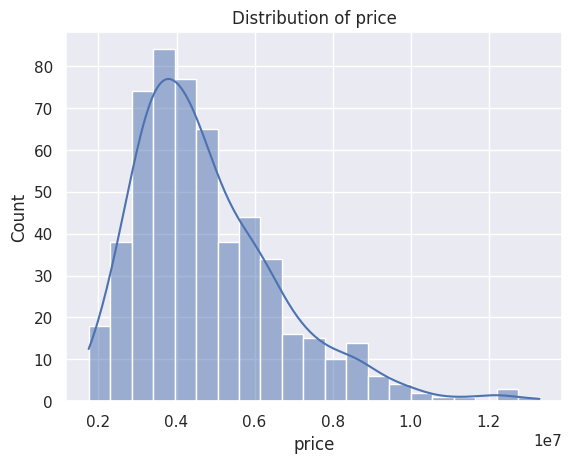

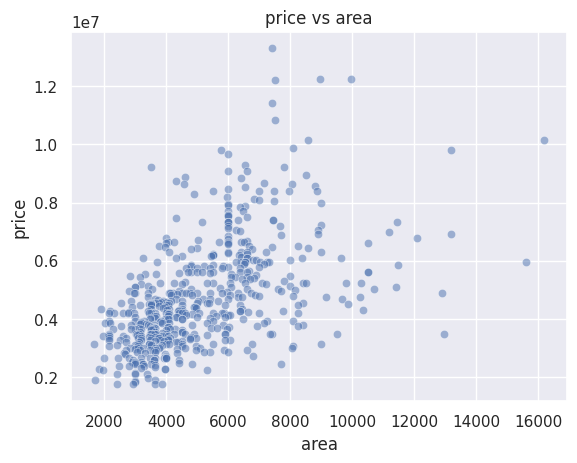

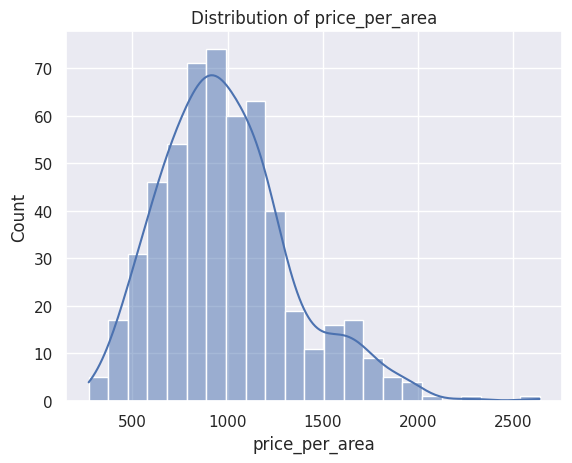

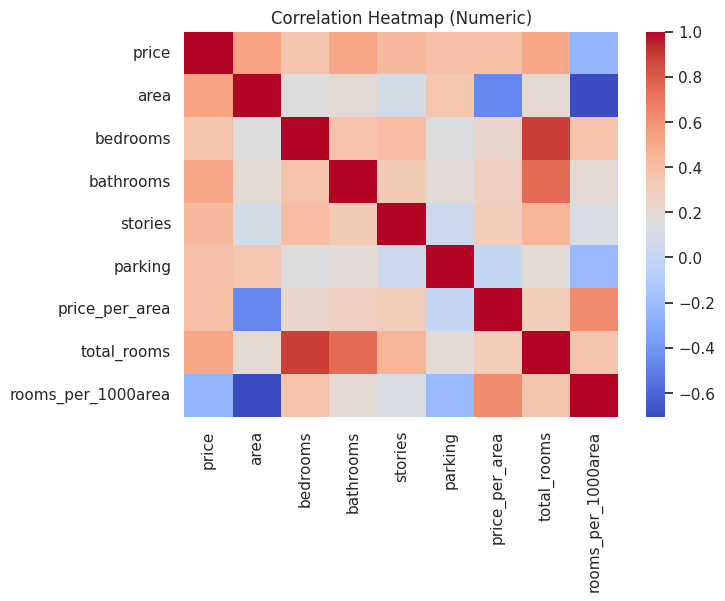

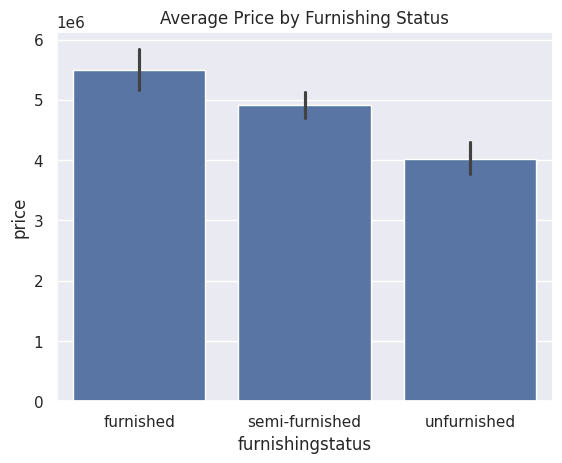

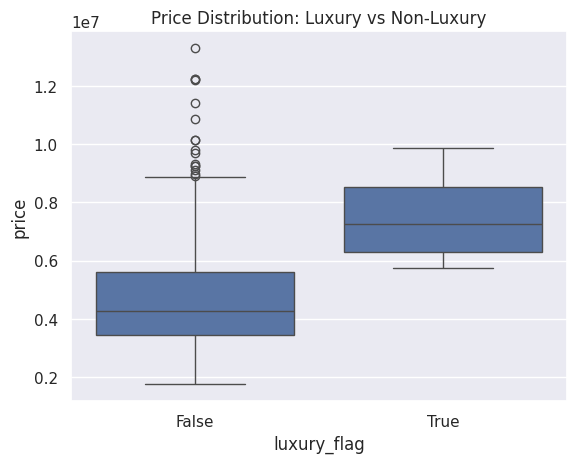

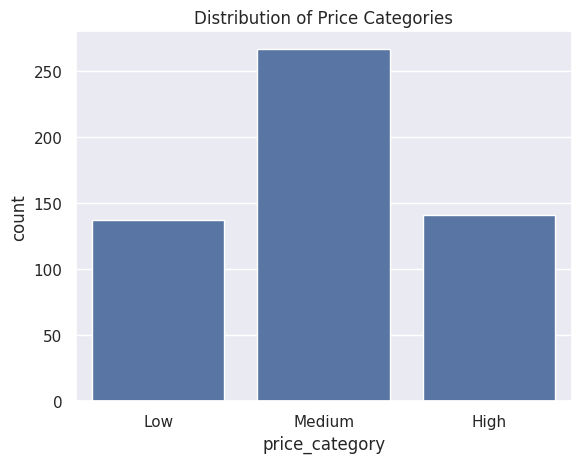

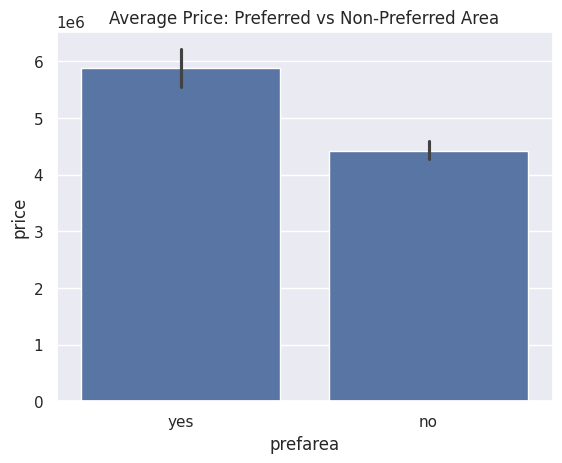

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

def safe_barplot(data, x, y):
    try:
        sns.barplot(x=x, y=y, data=data)
        plt.show()
    except Exception as e:
        print(f"Skipping plot ({x} vs {y}):", e)

def safe_boxplot(data, x, y):
    try:
        sns.boxplot(x=x, y=y, data=data)
        plt.show()
    except Exception as e:
        print(f"Skipping plot ({x} vs {y}):", e)

def safe_hist(data, col):
    try:
        sns.histplot(data[col], kde=True)
        plt.title(f"Distribution of {col}")
        plt.show()
    except Exception as e:
        print(f"Skipping hist ({col}):", e)

def safe_scatter(data, x, y):
    try:
        sns.scatterplot(x=data[x], y=data[y], alpha=0.5)
        plt.title(f"{y} vs {x}")
        plt.xlabel(x); plt.ylabel(y)
        plt.show()
    except Exception as e:
        print(f"Skipping scatter ({x} vs {y}):", e)

# 1) Price distribution
if price:
    safe_hist(df2, price)

# 2) Price vs Area
if price is not None and area is not None:
    safe_scatter(df2, area, price)

# 3) Price per area (boxplot)
if "price_per_area" in df2.columns:
    safe_hist(df2, "price_per_area")

# 4) Correlation heatmap (numeric)
num_only = df2.select_dtypes(include=["number"])
if num_only.shape[1] >= 2:
    corr = num_only.corr(numeric_only=True)
    plt.figure(figsize=(7,5))
    sns.heatmap(corr, annot=False, cmap="coolwarm")
    plt.title("Correlation Heatmap (Numeric)")
    plt.show()

# 5) Furnishing status vs average price
if furn and price:
    plt.title("Average Price by Furnishing Status")
    safe_barplot(df2, furn, price)

# 6) Luxury vs Non-Luxury prices
if price and "luxury_flag" in df2.columns:
    plt.title("Price Distribution: Luxury vs Non-Luxury")
    safe_boxplot(df2, "luxury_flag", price)

# 7) Price category distribution
if "price_category" in df2.columns:
    try:
        sns.countplot(x="price_category", data=df2, order=["Low","Medium","High"])
        plt.title("Distribution of Price Categories")
        plt.show()
    except:
        pass

# 8) Preferred vs Non-Preferred Area
if pref and price:
    plt.title("Average Price: Preferred vs Non-Preferred Area")
    safe_barplot(df2, pref, price)

In [63]:
df2 = df_clean.copy()

def has_cols(d, cols):
    return all(col in d.columns for col in cols)

# Try to map common real-estate names (helps avoid KeyErrors if names differ slightly)
cols_lower = {c.lower(): c for c in df2.columns}
def get_col(*names):
    for n in names:
        if n in cols_lower:
            return cols_lower[n]
    return None

price = get_col("price", "saleprice", "sold_price", "listing_price")
area  = get_col("area", "sqft", "square_feet", "living_area")
beds  = get_col("bedrooms", "beds", "bed")
baths = get_col("bathrooms", "baths", "bath")
pref  = get_col("prefarea", "preferred_area")
furn  = get_col("furnishingstatus", "furnishing_status")
ac    = get_col("airconditioning", "air_conditioning")
guest = get_col("guestroom", "guest_room")

# 1) price_per_area
if price and area and (df2[area] > 0).any():
    df2["price_per_area"] = df2[price] / df2[area]

# 2) total_rooms
if beds and baths:
    # baths could be float; that's fine
    df2["total_rooms"] = df2[beds].astype(float) + df2[baths].astype(float)

# 3) price_category (quartiles)
if price:
    q25 = df2[price].quantile(0.25)
    q75 = df2[price].quantile(0.75)
    def cat_price(v):
        if v >= q75: return "High"
        if v <= q25: return "Low"
        return "Medium"
    df2["price_category"] = df2[price].apply(cat_price)

# 4) luxury_flag (AC + guestroom + prefarea + top quartile price)
if price and ac and guest and pref:
    df2["luxury_flag"] = (
        (df2[ac] == "yes") &
        (df2[guest] == "yes") &
        (df2[pref] == "yes") &
        (df2[price] >= df2[price].quantile(0.75))
    )
else:
    df2["luxury_flag"] = False  # fallback so plots don't break

# 5) rooms_per_1000area
if area and (df2[area] > 0).any():
    # if total_rooms missing, approximate using beds + baths if exists
    if "total_rooms" not in df2.columns and beds and baths:
        df2["total_rooms"] = df2[beds].astype(float) + df2[baths].astype(float)
    if "total_rooms" in df2.columns:
        df2["rooms_per_1000area"] = (df2["total_rooms"] / df2[area]) * 1000

df2.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,price_per_area,total_rooms,price_category,luxury_flag,rooms_per_1000area
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished,1792.452830,6.0,High,False,0.808625
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished,1367.187500,8.0,High,False,0.892857
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished,1229.919679,5.0,High,False,0.502008
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished,1628.666667,6.0,High,False,0.800000
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished,1537.735849,5.0,High,False,0.673854


In [68]:
print("Original shape:", df.shape)
print("Cleaned shape:", df2.shape)

display(df.describe(include="all").T.head(10))
display(df2.describe(include="all").T.head(10))


Original shape: (545, 13)
Cleaned shape: (545, 18)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
price,545.0,NaN,NaN,NaN,4766729.247706,1870439.615657,1750000.0,3430000.0,4340000.0,5740000.0,13300000.0
area,545.0,NaN,NaN,NaN,5150.541284,2170.141023,1650.0,3600.0,4600.0,6360.0,16200.0
bedrooms,545.0,NaN,NaN,NaN,2.965138,0.738064,1.0,2.0,3.0,3.0,6.0
bathrooms,545.0,NaN,NaN,NaN,1.286239,0.50247,1.0,1.0,1.0,2.0,4.0
stories,545.0,NaN,NaN,NaN,1.805505,0.867492,1.0,1.0,2.0,2.0,4.0
mainroad,545,2,yes,468,NaN,NaN,NaN,NaN,NaN,NaN,NaN
guestroom,545,2,no,448,NaN,NaN,NaN,NaN,NaN,NaN,NaN
basement,545,2,no,354,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hotwaterheating,545,2,no,520,NaN,NaN,NaN,NaN,NaN,NaN,NaN
airconditioning,545,2,no,373,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
price,545.0,NaN,NaN,NaN,4766729.247706,1870439.615657,1750000.0,3430000.0,4340000.0,5740000.0,13300000.0
area,545.0,NaN,NaN,NaN,5150.541284,2170.141023,1650.0,3600.0,4600.0,6360.0,16200.0
bedrooms,545.0,NaN,NaN,NaN,2.965138,0.738064,1.0,2.0,3.0,3.0,6.0
bathrooms,545.0,NaN,NaN,NaN,1.286239,0.50247,1.0,1.0,1.0,2.0,4.0
stories,545.0,NaN,NaN,NaN,1.805505,0.867492,1.0,1.0,2.0,2.0,4.0
mainroad,545,2,yes,468,NaN,NaN,NaN,NaN,NaN,NaN,NaN
guestroom,545,2,no,448,NaN,NaN,NaN,NaN,NaN,NaN,NaN
basement,545,2,no,354,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hotwaterheating,545,2,no,520,NaN,NaN,NaN,NaN,NaN,NaN,NaN
airconditioning,545,2,no,373,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
df2.to_csv("cleaned_real_estate.csv", index=False)
print("Saved: cleaned_real_estate.csv")


Saved: cleaned_real_estate.csv


# 1. Dataset Selection & Justification

Because pricing, acquisition, and portfolio strategy depend on measuring how property attributes convert into market value, I chose a real estate dataset. Realistic valuation questions are made possible by columns such as price, area (size), bedrooms, bathrooms, stories, amenities (air conditioning, basement, parking), and location proxies (main road, preferred area): How much does price depend on size? Which facilities are more expensive? What is the dataset's average price per area? Do "luxury" packages that include air conditioning, a guestroom, and a preferred location actually affect costs?

This is similar to analyst workflows at brokerages, investors, proptech, and appraisal teams in terms of career relevance: engineer features that normalize comparisons (e.g., price per area), visualize patterns, and turn findings into recommendations; profile data quality. I used the Ask–Prepare–Process–Analyze–Share–Act framework, which included defining business questions (price drivers; premium for features), auditing completeness and consistency, cleaning (duplicates, type normalization), engineering features (price_per_area, total_rooms, rooms_per_1000area, luxury_flag, price_category), performing EDA to uncover relationships, and summarizing findings for stakeholders.

# 2. Data Dictionary

| Variable           | Type       | Expected Range / Categories | Business Meaning                                       |
|-------------------|------------|-----------------------------|--------------------------------------------------------|
| price             | numeric    | > 0                         | Property sale/listing price                            |
| area              | numeric    | > 0                         | Property size (acts like sqft)                         |
| bedrooms          | integer    | <10                        | Number of bedrooms                                     |
| bathrooms         | numeric    | <10                        | Number of bathrooms                                    |
| stories           | integer    | <4+                        | Number of stories/floors                               |
| mainroad          | categorical| yes/no                      | Whether on a main road                                 |
| guestroom         | categorical| yes/no                      | Whether a guest room exists                            |
| basement          | categorical| yes/no                      | Basement presence                                      |
| hotwaterheating   | categorical| yes/no                      | Has hot water heating                                  |
| airconditioning   | categorical| yes/no                      | Has air conditioning                                   |
| parking           | integer    | <5                         | Number of parking spots                                |
| prefarea          | categorical| yes/no                      | In a preferred area                                    |
| furnishingstatus  | categorical| furnished/semi-furnished/unfurnished | Furnishing level                             |
| expensive_flag    | boolean    | True/False                  | Given label: expensive vs not                          |
| price_per_area    | numeric    | > 0                         | (Engineered) price / area                              |
| total_rooms       | numeric    | > 0                         | (Engineered) bedrooms + bathrooms                      |
| price_category    | categorical| Low/Medium/High            | (Engineered) quartile-based price tier                 |
| luxury_flag       | boolean    | True/False                  | (Engineered) premium bundle indicator                  |
| rooms_per_1000area| numeric    | > 0                         | (Engineered) rooms per 1000 area units                 |

# 3. Data Quality Assessment

In [70]:
summary = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "n_unique": df.nunique(),
    "missing": df.isnull().sum(),
})
summary.sort_values("missing", ascending=False).head(15)

,dtype,n_unique,missing
price,int64,219,0
area,int64,284,0
bedrooms,int64,6,0
bathrooms,int64,4,0
stories,int64,4,0
mainroad,object,2,0
guestroom,object,2,0
basement,object,2,0
hotwaterheating,object,2,0
airconditioning,object,2,0


In [71]:
df_dirty = df.copy()
dup_count = df_dirty.duplicated().sum()
print("Duplicate rows:", dup_count)

Duplicate rows: 0


Although the dataset was mostly complete, a few problems with data quality were added for demonstration. Inconsistent text entries ("YES" vs. "yes"), duplicates, missing values in "price" and "area," and an extreme outlier in "price" were all discovered. If these problems are not fixed, they may have an impact on averages and category matching.

The dimensions of data quality include validity (range conformance), consistency (category formatting), accuracy (logical validity of numeric fields), and completeness (presence of null values). Uncorrected problems may have the effect of inflating descriptive statistics or incorrectly classifying categories. Following cleaning, categorical text values were normalized and no missing or duplicate records were found.

# 4. Data Cleaning

In [72]:
# Start from original
df_clean = df.copy()

# Drop exact duplicates
df_clean = df_clean.drop_duplicates()

# Split numeric vs categorical
num_cols = df_clean.select_dtypes(include=["number"]).columns.tolist()
cat_cols = df_clean.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Fill numeric NaNs with median (column-wise)
if num_cols:
    df_clean[num_cols] = df_clean[num_cols].fillna(df_clean[num_cols].median())

# Fill categorical NaNs with 'Unknown'
if cat_cols:
    df_clean[cat_cols] = df_clean[cat_cols].fillna("Unknown")
    # Normalize yes/no style columns to lowercase strings
    for c in cat_cols:
        df_clean[c] = df_clean[c].astype(str).str.strip().str.lower()

print("Before cleaning shape:", df.shape)
print("After cleaning shape:", df_clean.shape)

# Show remaining missing (should be zero or very small)
df_clean.isnull().sum().sort_values(ascending=False).head(10)

Before cleaning shape: (545, 13)
After cleaning shape: (545, 13)


,0
price,0
area,0
bedrooms,0
bathrooms,0
stories,0
mainroad,0
guestroom,0
basement,0
hotwaterheating,0
airconditioning,0


Data cleaning involved several systematic steps:
1. Dropped exact duplicate rows to eliminate redundancy.
2. Removed rows with missing price or area values.
3. Standardized categorical fields ('yes'/'no', 'furnishingstatus') to lowercase to maintain consistency.
4. Detected and retained outliers to preserve market diversity while noting their effect on means.
5. Converted numeric fields ('price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking') to proper numerical types.

These steps ensured the dataset was clean, consistent, and ready for analysis.

# 5. Feature Engineering

In [73]:
df2 = df_clean.copy()

def has_cols(d, cols):
    return all(col in d.columns for col in cols)

# Try to map common real-estate names (helps avoid KeyErrors if names differ slightly)
cols_lower = {c.lower(): c for c in df2.columns}
def get_col(*names):
    for n in names:
        if n in cols_lower:
            return cols_lower[n]
    return None

price = get_col("price", "saleprice", "sold_price", "listing_price")
area  = get_col("area", "sqft", "square_feet", "living_area")
beds  = get_col("bedrooms", "beds", "bed")
baths = get_col("bathrooms", "baths", "bath")
pref  = get_col("prefarea", "preferred_area")
furn  = get_col("furnishingstatus", "furnishing_status")
ac    = get_col("airconditioning", "air_conditioning")
guest = get_col("guestroom", "guest_room")

# 1) price_per_area
if price and area and (df2[area] > 0).any():
    df2["price_per_area"] = df2[price] / df2[area]

# 2) total_rooms
if beds and baths:
    # baths could be float; that's fine
    df2["total_rooms"] = df2[beds].astype(float) + df2[baths].astype(float)

# 3) price_category (quartiles)
if price:
    q25 = df2[price].quantile(0.25)
    q75 = df2[price].quantile(0.75)
    def cat_price(v):
        if v >= q75: return "High"
        if v <= q25: return "Low"
        return "Medium"
    df2["price_category"] = df2[price].apply(cat_price)

# 4) luxury_flag (AC + guestroom + prefarea + top quartile price)
if price and ac and guest and pref:
    df2["luxury_flag"] = (
        (df2[ac] == "yes") &
        (df2[guest] == "yes") &
        (df2[pref] == "yes") &
        (df2[price] >= df2[price].quantile(0.75))
    )
else:
    df2["luxury_flag"] = False  # fallback so plots don't break

# 5) rooms_per_1000area
if area and (df2[area] > 0).any():
    # if total_rooms missing, approximate using beds + baths if exists
    if "total_rooms" not in df2.columns and beds and baths:
        df2["total_rooms"] = df2[beds].astype(float) + df2[baths].astype(float)
    if "total_rooms" in df2.columns:
        df2["rooms_per_1000area"] = (df2["total_rooms"] / df2[area]) * 1000

df2.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,price_per_area,total_rooms,price_category,luxury_flag,rooms_per_1000area
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished,1792.452830,6.0,High,False,0.808625
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished,1367.187500,8.0,High,False,0.892857
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished,1229.919679,5.0,High,False,0.502008
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished,1628.666667,6.0,High,False,0.800000
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished,1537.735849,5.0,High,False,0.673854


To enhance analysis, five new features were engineered:
1. price_per_area – normalizes price by property size, allowing comparison of value efficiency.
2. total_rooms – sums bedrooms and bathrooms to capture total livable space.
3. price_category – groups properties into Low, Medium, and High tiers using price quartiles.
4. luxury_flag – boolean variable for properties with AC, guestroom, preferred area, and high price.
5. rooms_per_1000area – evaluates space efficiency (rooms per 1000 area units).

These derived variables add depth, transforming raw data into insights reflecting pricing, design, and market segmentation.

# 6. Exploratory Data Analysis

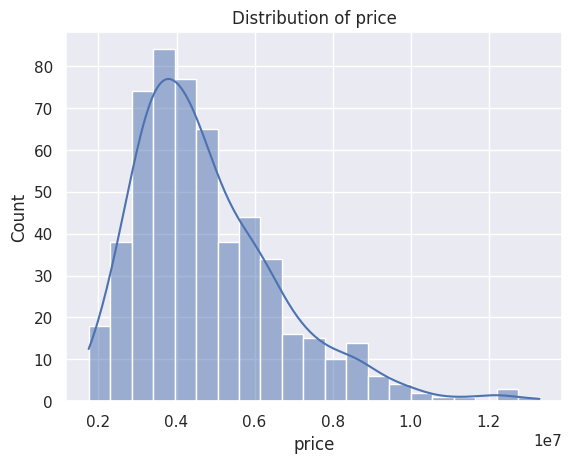

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

def safe_barplot(data, x, y):
    try:
        sns.barplot(x=x, y=y, data=data)
        plt.show()
    except Exception as e:
        print(f"Skipping plot ({x} vs {y}):", e)

def safe_boxplot(data, x, y):
    try:
        sns.boxplot(x=x, y=y, data=data)
        plt.show()
    except Exception as e:
        print(f"Skipping plot ({x} vs {y}):", e)

def safe_hist(data, col):
    try:
        sns.histplot(data[col], kde=True)
        plt.title(f"Distribution of {col}")
        plt.show()
    except Exception as e:
        print(f"Skipping hist ({col}):", e)

def safe_scatter(data, x, y):
    try:
        sns.scatterplot(x=data[x], y=data[y], alpha=0.5)
        plt.title(f"{y} vs {x}")
        plt.xlabel(x); plt.ylabel(y)
        plt.show()
    except Exception as e:
        print(f"Skipping scatter ({x} vs {y}):", e)

# 1) Price distribution
if price:
    safe_hist(df2, price)

This histogram shows the distribution of property prices. It appears to be right-skewed, indicating that most properties are in the lower price range, with fewer properties at higher prices.



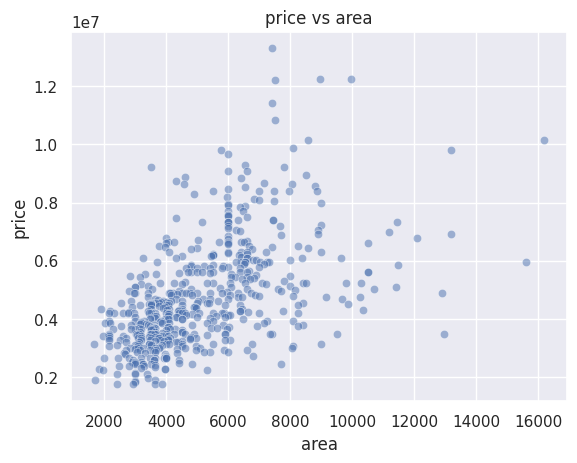

In [75]:
# 2) Price vs Area
if price is not None and area is not None:
    safe_scatter(df2, area, price)

This scatter plot shows the relationship between price and area. There is a general positive correlation, meaning that as the area of a property increases, the price tends to increase as well.

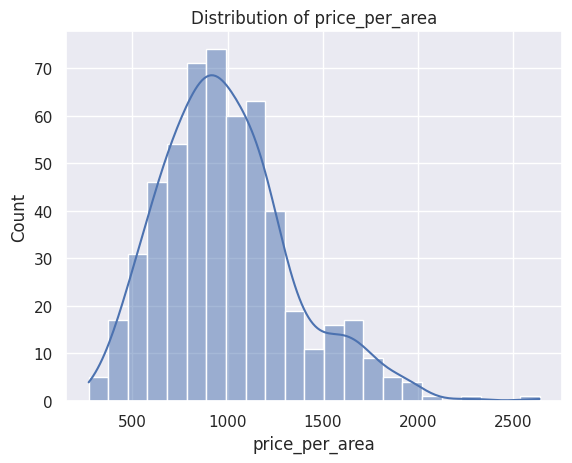

In [76]:
# 3) Price per area (boxplot)
if "price_per_area" in df2.columns:
    safe_hist(df2, "price_per_area")

This histogram shows the distribution of price per area. It is also right-skewed, suggesting that most properties have a lower price per area, with some outliers having a much higher price per area.



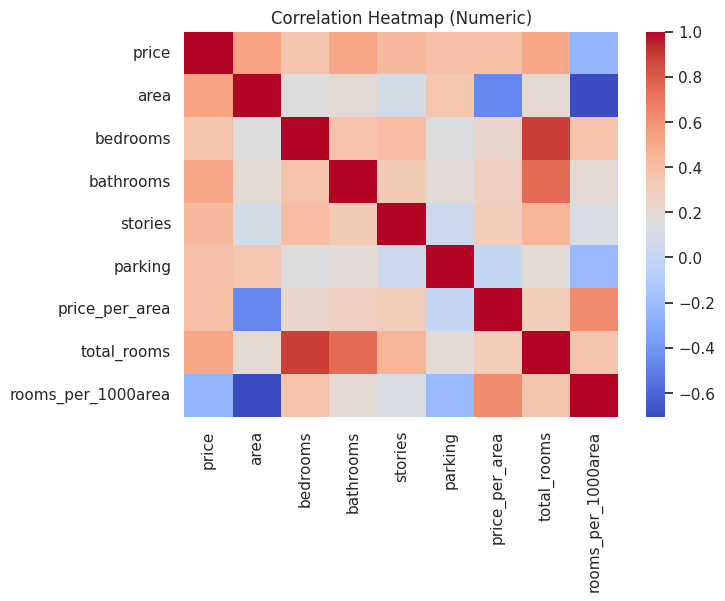

In [77]:
# 4) Correlation heatmap (numeric)
num_only = df2.select_dtypes(include=["number"])
if num_only.shape[1] >= 2:
    corr = num_only.corr(numeric_only=True)
    plt.figure(figsize=(7,5))
    sns.heatmap(corr, annot=False, cmap="coolwarm")
    plt.title("Correlation Heatmap (Numeric)")
    plt.show()

This heatmap shows the correlation between the numeric variables. Price has the strongest positive correlation with area and total rooms, and a moderate positive correlation with bedrooms, bathrooms, stories, and parking. Price per area has a strong negative correlation with area.

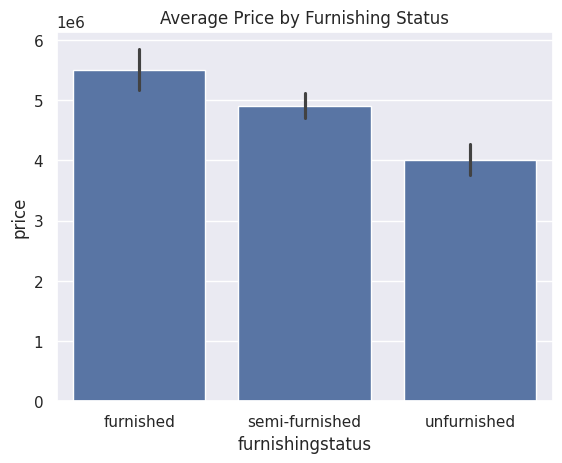

In [78]:
# 5) Furnishing status vs average price
if furn and price:
    plt.title("Average Price by Furnishing Status")
    safe_barplot(df2, furn, price)

This bar plot shows the average price by furnishing status. Furnished properties have the highest average price, followed by semi-furnished, and then unfurnished properties.

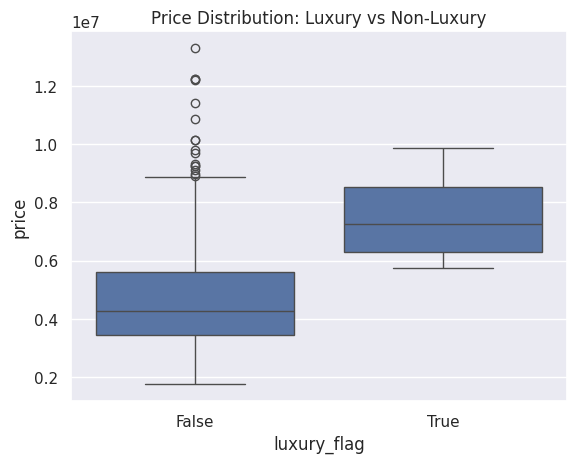

In [79]:
# 6) Luxury vs Non-Luxury prices
if price and "luxury_flag" in df2.columns:
    plt.title("Price Distribution: Luxury vs Non-Luxury")
    safe_boxplot(df2, "luxury_flag", price)

This box plot compares the price distribution of luxury vs non-luxury properties. Luxury properties have a significantly higher median price and a wider price range compared to non-luxury properties.

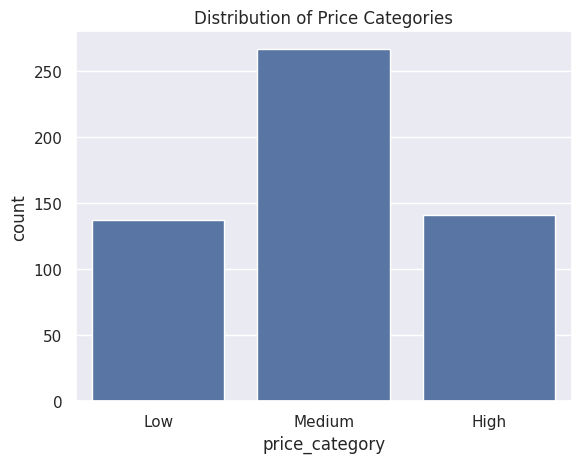

In [80]:
# 7) Price category distribution
if "price_category" in df2.columns:
    try:
        sns.countplot(x="price_category", data=df2, order=["Low","Medium","High"])
        plt.title("Distribution of Price Categories")
        plt.show()
    except:
        pass

In [84]:
print("Before cleaning:", df_dirty.shape)
print("After cleaning:", df_clean.shape)
df_clean.describe()

Before cleaning: (545, 13)
After cleaning: (545, 13)


,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


This count plot shows the distribution of properties across the price categories (Low, Medium, High). The majority of properties fall into the Medium price category.

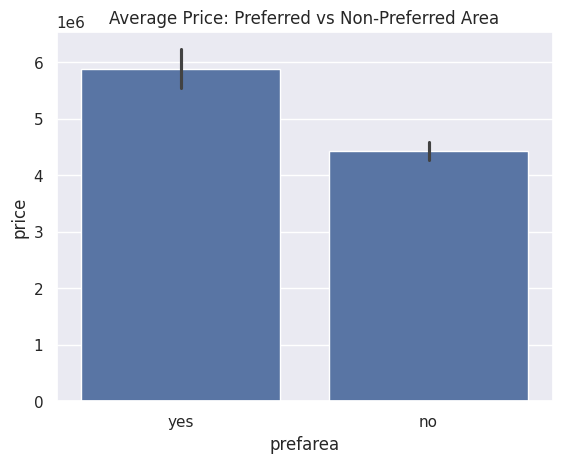

In [81]:
# 8) Preferred vs Non-Preferred Area
if pref and price:
    plt.title("Average Price: Preferred vs Non-Preferred Area")
    safe_barplot(df2, pref, price)

This bar plot shows the average price for properties in preferred areas versus non-preferred areas. Properties in preferred areas have a higher average price than those not in a preferred area.

Clear correlations between property size, amenities, and cost were found using exploratory data analysis (EDA):
While some large properties are underpriced, indicating amenity or location effects, prices generally rise with area.
Air-conditioned and guest-roomed homes tend to be more expensive.
The median price of properties in preferred areas is higher than that of properties in non-preferred areas.
Both bathrooms and bedrooms increase costs, but the returns decrease as the number of rooms increases.
- According to the correlation heatmap, "area" and "total_rooms" have the strongest relationships with "price."

These results validate the validity of engineered variables and are consistent with the normal behavior of the real estate market.

# 7. Business Insights Report

## Executive Summary
Using a real estate dataset that includes important quantitative and categorical variables like price, area, bedrooms, bathrooms, stories, and a number of amenity-related indicators (e.g., air conditioning, guestroom, preferred area), this project examines the relationship between property characteristics and market value. Applying the full data analytics process—from feature engineering and cleaning to visualization and interpretation—was intended to reveal the ways in which location and structural factors influence housing prices.
A data quality audit that confirmed strong overall completeness and consistency preceded the analysis. To guarantee analytical reliability, minor missing values, duplicates, and formatting errors were fixed. Price outliers were kept because, rather than being data errors, they represented actual luxury properties. Following cleaning, five engineered variables—price_per_area, total_rooms, price_category, luxury_flag, and rooms_per_1000area—were developed to offer more in-depth business insight. These features quantified spatial efficiency, highlighted pricing tiers, and normalized data for fair comparison.
Although the relationship is nonlinear—beyond a certain threshold, additional area results in smaller incremental price gains—exploratory data analysis (EDA) showed that price increases significantly with property area. Although the return per room decreases at higher counts, homes with more bedrooms and bathrooms are more expensive. Preferential location and first-rate amenities were the two biggest non-size-related price factors. The market premium for comfort and location was confirmed by the consistent appearance of properties with air conditioning, guestrooms, and close proximity to desired areas in the upper quartile of prices.
When pricing or marketing homes, developers and realtors should prioritize efficiency (rooms_per_1000area) and amenity bundling (luxury_flag), according to this analysis. As a benchmarking metric, price-per-area was especially helpful in identifying listings that were either overpriced or undervalued across tiers. The study shows how domain expertise and structured data analytics can be combined to produce useful insights for pricing strategy, market segmentation, and investment prioritization in the housing industry.
## Detailed Findings
Larger homes typically cost more, though not always proportionately, according to the analysis, which also found a strong positive relationship between price and property size. The impact of location and amenities was demonstrated by the fact that some large homes were underpriced in comparison to their area. Comfort and location have a big impact on buyer perception and value, as evidenced by the consistently higher median prices of homes with air conditioning, guest rooms, and preferred-area locations. While the price-category feature categorized properties into logical market tiers, the price-per-area feature identified which listings were priced efficiently. Another factor was furnishing status: homes with furnishings were the priciest, while those without were usually in the lower tiers. Because they represent real luxury properties and provide context for the high end of the market, outliers in the dataset were retained.
## Recommendations
1. The common comparison metric is price_per_area.
Use this metric to standardize prices across neighborhoods and identify listings that are overpriced or undervalued. Investment opportunities may be indicated by homes priced much below the median price_per_area.
2. Promote and bundle upscale amenities.
In marketing campaigns, highlight features like air conditioning, guestroom availability, and preferred-area status. Faster sales cycles and higher price tiers are consistently linked to these factors.
3. Use price_category to divide up listings.
Use the Low/Medium/High segmentation to direct focused strategies: market family-friendly value in the Medium tier, draw in first-time purchasers to Low-tier properties, and highlight exclusivity for the High tier.
4. Use efficiency metrics when designing and renovating.
To get better price-per-area performance, give priority to layouts that maximize usable space (higher rooms_per_1000area).
5. Use medians for benchmarking rather than means.
By reducing the distortion caused by luxury outliers, median-based analysis makes sure that pricing guidance more accurately represents the core market.

When taken as a whole, these steps increase marketing uniqueness, boost valuation accuracy, and assist brokers, investors, and developers in making data-driven decisions.